## Practical task 1 - working with relatively big input (doesn't fit memory)

    obtain wiki.txt and wiki_corp.txt files
    write a python code which will compute how many times the word Jesus appear in wiki.txt
    do the same using unix utils only (aws, grep, etc.)
    optional: evaluate speed for both implementation

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/My Drive/AI")

In [0]:
import re

In [0]:
file = open('slice_wiki3.txt').read()

### Using RegEx

In [0]:
jesuses = re.findall('Jesus', file)    

In [0]:
jesuses

In [0]:
len(jesuses)

### Using iteration over file

In [0]:
file2 = open('slice_wiki3.txt')

In [0]:
line = file2.readline()

In [0]:
line

*Find Jesuses, assuming that there is only one Jesus in one line*

In [0]:
import time

In [0]:
t0 = time.clock()
count = 0
for line in file2:
    if "Jesus" in line:
        count += 1
t_python = time.clock() - t0
print("Time for Python implementation: " "{:f}".format(t_python))      
print(count)

### Using Unix Utils

In [0]:
t0 = time.clock()
count2 = !cat slice_wiki3.txt | grep Jesus | wc -l
t_unix = time.clock() - t0
print("Time for Unix implementation: " "{:f}".format(t_unix))      
print(count2)

## Practical task 2 - words count using awk

Write and run an awk program to compute how many times a word appear in an input file. Note: you can use any combinations of unix utilities, but remebmber - shorter and more efficient code is better.

Additionaly: sort words in descending order.

Consider a piese of wak code above as an example

*For testing purpose please use wiki.txt file OR it's slice obtained by head/tail combination

*It would be better to use ALWAYS lowercased input. To do so, preprocess things using tr unix utility

### Lowercase input

In [0]:
!cat slice_wiki3.txt | tr [:upper:] [:lower:] | tr -d [.] > slice_wiki.txt

In [0]:
!head -n 10 slice_wiki.txt

In [0]:
!apt-get install bc

### Counting words and selecting count for Jesus

In [0]:
!awk '{for(i=1;i<=NF;i++) a[$i]++} END {for(k in a) print k,a[k]}' slice_wiki.txt | grep "jesus [0-9]*" | grep -Eo '[0-9]+' | paste -s -d+ | bc 

In [0]:
!awk '{for(i=1;i<=NF;i++) if ($i=="jesus") a[$i]++} END {print a["jesus"]}' slice_wiki.txt 

In [0]:
!awk '/jesus/ {a++} END {print a}' slice_wiki.txt

# Practical task 3 - Sentense count using grep and regex

Consider english sentence to be a thing with latinic symbols and spaces, started with "Capitalized" symbol and finished with "".?!""

Using grep and regular expressions find number of english sentences in wiki_corp.txt OR it's slice (head/tail)

### Counting with RegEx

In [0]:
!cat slice_wiki3.txt | grep -e '\b[A-Z][a-zA-Z ]\+[\.\?\!]$' | wc -l

### Counting uniq sentences

In [0]:
stuff2 = !cat slice_wiki3.txt | grep -e '\b[A-Z][a-zA-Z ]\+[\.\?!]$'

In [0]:
s2 = set(stuff2)

In [0]:
len(s2)

In [0]:
stuff2[2000:2020]

## Practical task 4 - Using twitter as a data source

Register Twitter Development access. See here. Get your individual keys pack (4 different encrypted strings) Consider a piece of code above as an example. Implement your own twitter puller for any given set of hashtags. Save twitts text into any storage (tsv would work well). Run it for several minutes. Further we will work with an output.

Using pandas (matplotlib is acceptable despite being a topic of upcoming lessons) visualize following statistisc:

    total rate of massages per minute
    frequency of english words in output
    find a value of length of a longest word


### Installing needed modules

In [0]:
!pip3 install tweepy
import tweepy

In [0]:
import json
import re
import csv
import time
from datetime import datetime
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener


### Loading access keys

In [0]:
# Variables that contains the user credentials to access Twitter API
with open('secret') as f:
    secret = json.loads(f.read())

In [0]:
consumer_key = secret['consumer_key']
consumer_secret = secret['consumer_secret']
access_token = secret['access_token']
access_token_secret = secret['access_token_secret']

### Starting twitter listener

In [0]:
# This is a basic listener that just prints received tweets to stdout.
def body_cleanup(text):
    # Here you can put any pre-processing routines
    return text

def preproc(tweet):
    txt = body_cleanup(tweet['text'])
    data = {'text': txt, 'src': 'twitter'}
    if 'user' in tweet:
        data['user_location'] = tweet['user']['location']
    else:
        data['location'] = None
        
    if tweet['place'] != None:
        data['country'] = tweet['place']['country']
    else:
        data['country'] = None
        
    if 'created_at' in tweet:
        time_struct = time.strptime(tweet['created_at'], "%a %b %d %H:%M:%S +0000 %Y")
        data['created_at'] = int(time.mktime(time_struct))
        #clean_timestamp = time.strptime(tweet['created_at'], '%a %b %d %H:%M:%S +0000 %Y')        
    #to_prn = json.dumps(tweet)
    to_prn = json.dumps(data)
    return to_prn, data


In [0]:
class StdOutListener(StreamListener):
    ''' Handles data received from the stream. '''

    def __init__(self, filename):
        StreamListener.__init__(self)
        self.filename = filename
        # if file is empty - add header
        if not os.path.isfile(filename):            
            self.save_row({'text':'text', 'src':'src', 'user_location':'user_location', 'country':'country', 'created_at':'created_at'})            

    def on_data(self, data):
        tweet = json.loads(data)
        # Prints the text of the tweet
        if 'text' in tweet:
            for_print, for_db = preproc(tweet)
            print(for_print)
            self.save_row(for_db)
        return True

    def save_row(self, row):
        to_save = []
        for item in row:
            to_save.append(row[item])
        with open(self.filename, 'a+', encoding='utf-8') as f:
            self.tsv_writer = csv.writer(f, delimiter='\t')
            self.tsv_writer.writerow(to_save)

    def on_error(self, status_code):
        print('Got an error with status code: ' + str(status_code))
        return True # To continue listening

    def on_timeout(self):
        print('Timeout...')
        return True # To continue listening


In [0]:
# OAuth process, using the keys and tokens
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Creation of the actual interface, using authentication
api = tweepy.API(auth)

listener = StdOutListener('c_switzerland.tsv')
stream = Stream(auth, listener)
stream.filter(track=['switzerland'], languages=['en'])

In [0]:
#!truncate -s 0 twitbase.tsv

In [0]:
!head twitbase2.tsv

### Loading Pandas DataFrame fom tsv

In [0]:
import pandas as pd

In [0]:
ds_twits = 'twitbase2.tsv'
ua_twits = 'c_ukraine.tsv'
ca_twits = 'c_canada.tsv'
ch_twits = 'c_switzerland.tsv'

In [0]:
twits = pd.read_csv(ch_twits, sep='\t')

In [0]:
twits["created_at"] = twits["created_at"].apply(datetime.fromtimestamp)

In [14]:
twits.head(20)

,text,src,user_location,country,created_at
0,"RT @binance: Calling all Binancians in Italy, ...",twitter,UAE & india,NaN,2018-11-01 11:25:29
1,"Late autumn scenery of vineyards in Lavaux, Sw...",twitter,NaN,NaN,2018-11-01 11:25:31
2,This image is shot by photographer @surbhiikau...,twitter,"Mumbai, India",Switzerland,2018-11-01 11:25:31
3,RT @KaKaysKreations: @SeemaCMS Just sayin...Au...,twitter,"Atlanta, GA",NaN,2018-11-01 11:25:32
4,RT @etsedafeamekpor: When the fundamentals of ...,twitter,"The Hague, The Netherlands",NaN,2018-11-01 11:25:41
5,RT @UN_Women: Switzerland helped create @UN_Wo...,twitter,Iceland,NaN,2018-11-01 11:25:42
6,Switzerland reverses plans to sell weapons to ...,twitter,WORLD,NaN,2018-11-01 11:26:00
7,RT @ExeterMarine: MT @CidtheSquid57 &amp; @Jen...,twitter,NaN,NaN,2018-11-01 11:26:04
8,"#QuakeWatch: 1.5 - #Switzerland on Thu, 01/11/...",twitter,"Luton, England",NaN,2018-11-01 11:26:07
9,https://t.co/2GcKUeidrh\n\nSingapore model? \n...,twitter,Berlin | London,NaN,2018-11-01 11:26:09


In [15]:
twits.shape

(6054, 5)

### Counting tweets per minute and per hour

In [16]:
minute_twits = twits[['text', 'created_at']].groupby(pd.Grouper(key='created_at', freq="1min")).count()
minute_twits[(minute_twits.text) > 0].mean() 

text    8.455307
dtype: float64

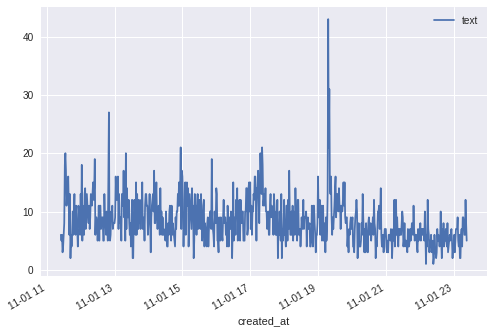

In [17]:
minute_twits[(minute_twits.text) > 0].plot()

In [18]:
hour_twits = twits[['text', 'created_at']].groupby(pd.Grouper(key='created_at', freq="H")).count()
hour_twits[(hour_twits.text) > 0] 

,text
created_at,
2018-11-01 11:00:00,311
2018-11-01 12:00:00,590
2018-11-01 13:00:00,590
2018-11-01 14:00:00,548
2018-11-01 15:00:00,544
2018-11-01 16:00:00,510
2018-11-01 17:00:00,629
2018-11-01 18:00:00,470
2018-11-01 19:00:00,643


### Counting frequency of english words and finding the longest word

In [0]:
!pip install lxml

In [20]:
from bs4 import BeautifulSoup
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def clean_text(text): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. Also converting words to lemmas.
    '''    
    text = BeautifulSoup(text, 'html.parser').get_text()    
    stripped_text = re.sub("(@[A-Za-z0-9_]+)|([\#\:])|(\w+:\/\/\S+)|(RT\s)", " ", text).lower().split()    
    join_text = ' '.join(stripped_text)
    return join_text
  
def clean_text_lemma(text, lemma=True): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. Also converting words to lemmas.
    '''
    wordnet_lemmatizer = WordNetLemmatizer()
    text = BeautifulSoup(text, 'html.parser').get_text()    
    stripped_text = re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT\s)", " ", text).lower().split()
    lemma_text = [wordnet_lemmatizer.lemmatize(word) for word in stripped_text]
    join_text = ' '.join(lemma_text)
    return join_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
twits["text_stripped"] = twits["text"].apply(clean_text)

In [0]:
twits['text_len'] = [len(t) for t in twits.text]

In [0]:
twits['stripped_len'] = [len(t) for t in twits.text_stripped]
#twits.drop(['len_stripped'],axis=1,inplace=True)

In [24]:
#twits = twits[['text', 'text_len', 'text_stripped', 'stripped_len', 'src', 'coordinates', 'place', 'created_at']]
twits.head(10)

,text,src,user_location,country,created_at,text_stripped,text_len,stripped_len
0,"RT @binance: Calling all Binancians in Italy, ...",twitter,UAE & india,NaN,2018-11-01 11:25:29,"calling all binancians in italy, switzerland, ...",140,127
1,"Late autumn scenery of vineyards in Lavaux, Sw...",twitter,NaN,NaN,2018-11-01 11:25:31,"late autumn scenery of vineyards in lavaux, sw...",120,79
2,This image is shot by photographer @surbhiikau...,twitter,"Mumbai, India",Switzerland,2018-11-01 11:25:31,this image is shot by photographer in switzerl...,136,94
3,RT @KaKaysKreations: @SeemaCMS Just sayin...Au...,twitter,"Atlanta, GA",NaN,2018-11-01 11:25:32,just sayin...australia austria belgium canada ...,140,109
4,RT @etsedafeamekpor: When the fundamentals of ...,twitter,"The Hague, The Netherlands",NaN,2018-11-01 11:25:41,when the fundamentals of the ag's cover up of ...,140,119
5,RT @UN_Women: Switzerland helped create @UN_Wo...,twitter,Iceland,NaN,2018-11-01 11:25:42,switzerland helped create & has been a top cor...,144,116
6,Switzerland reverses plans to sell weapons to ...,twitter,WORLD,NaN,2018-11-01 11:26:00,switzerland reverses plans to sell weapons to ...,116,79
7,RT @ExeterMarine: MT @CidtheSquid57 &amp; @Jen...,twitter,NaN,NaN,2018-11-01 11:26:04,mt & great to see presenting her research at m...,144,79
8,"#QuakeWatch: 1.5 - #Switzerland on Thu, 01/11/...",twitter,"Luton, England",NaN,2018-11-01 11:26:07,"quakewatch 1.5 - switzerland on thu, 01/11/201...",124,72
9,https://t.co/2GcKUeidrh\n\nSingapore model? \n...,twitter,Berlin | London,NaN,2018-11-01 11:26:09,"singapore model? brexiteers, have you ever bee...",140,89


In [0]:
word_count = {}
longest = ''
for index, row in twits.iterrows():
    row_words = row["text_stripped"].split()
    for word in row_words:
      if len(word) > len(longest):
        longest = word
      if word in word_count:
        word_count[word] += 1
      else:
        word_count[word] = 1       

In [26]:
len(word_count)

10461

In [0]:
sorted_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

In [28]:
print("Longest word:", longest, "with length of ", len(longest))

Longest word: model,fashion,make-up,mood,lips,eyes,hair,style,light,natural,lausanne,switzerland,beaut… with length of  89


In [0]:
sorted_words[0:50]

### Counting unique twits 

In [0]:
uniq_texts = set(twits['text_stripped'])

In [0]:
len(uniq_texts)

### Creating WordCloud

In [29]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 

    100% |████████████████████████████████| 368kB 26.3MB/s 


In [0]:
comment_words = ' '
stopwords = set(STOPWORDS) 
stopwords.add('rtit')
stopwords.add('devic')

In [0]:
all_words = ' '.join([words for words in twits['text_stripped'][1:7000]])

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


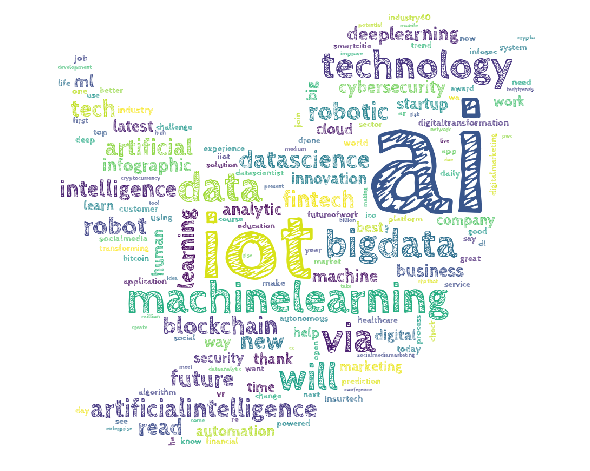

In [34]:
from scipy.misc import imread
from matplotlib import pyplot as plt
%matplotlib inline

twitter_mask = imread('twitter_mask.png', flatten=True)


wordcloud = WordCloud(width = 1000, height = 1000,
                font_path='CabinSketch-Bold.otf',
                background_color ='white', 
                stopwords = stopwords, 
                max_words = 150,
                collocations = False,                
                min_font_size = 10,
                mask=twitter_mask ).generate(all_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.savefig('./my_twitter_wordcloud_2.png', dpi=300)  
plt.show()

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


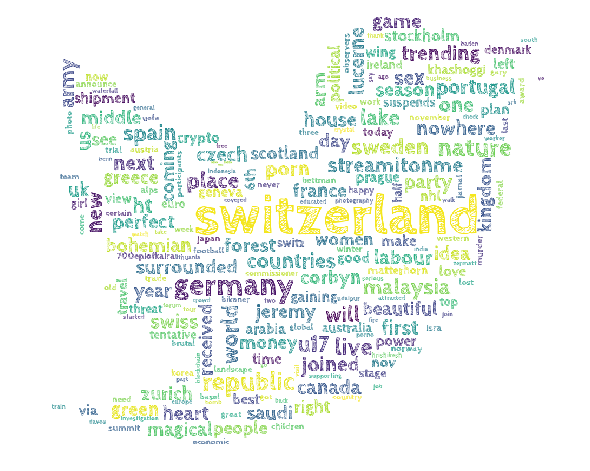

In [34]:
from scipy.misc import imread
from matplotlib import pyplot as plt
%matplotlib inline

twitter_mask3 = imread('twitter_mask.png', flatten=True)


wordcloud = WordCloud(width = 1000, height = 1000,
                font_path='CabinSketch-Bold.otf',
                background_color ='white', 
                stopwords = stopwords, 
                max_words = 420,
                collocations = False,                
                min_font_size = 10,
                mask=twitter_mask3).generate(all_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.savefig('./my_twitter_wordcloud_ch.png', dpi=300)  
plt.show()

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


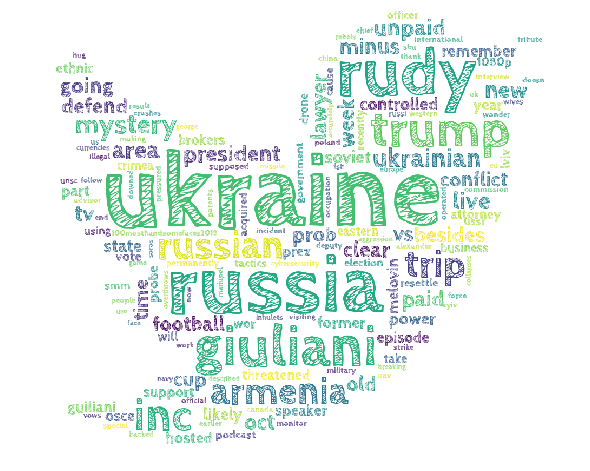

In [20]:
from scipy.misc import imread
from matplotlib import pyplot as plt
%matplotlib inline

twitter_mask = imread('twitter_mask.png', flatten=True)


wordcloud = WordCloud(width = 1000, height = 1000,
                font_path='CabinSketch-Bold.otf',
                background_color ='white', 
                stopwords = stopwords, 
                max_words = 150,
                collocations = False,                
                min_font_size = 10,
                mask=twitter_mask ).generate(all_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.savefig('./my_twitter_wordcloud_ua.png', dpi=300)  
plt.show()

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


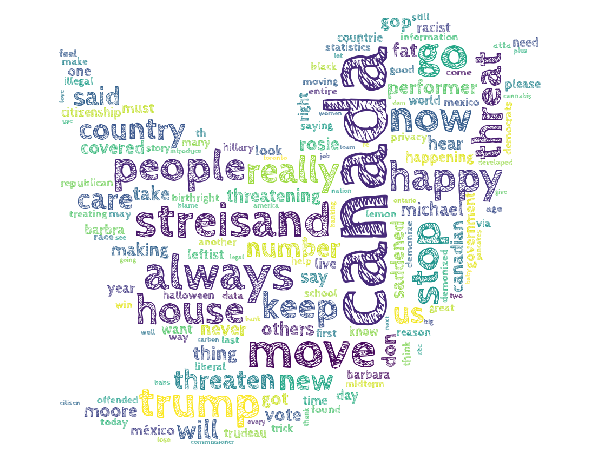

In [122]:
from scipy.misc import imread
from matplotlib import pyplot as plt
%matplotlib inline

twitter_mask = imread('twitter_mask.png', flatten=True)


wordcloud = WordCloud(width = 1000, height = 1000,
                font_path='CabinSketch-Bold.otf',
                background_color ='white', 
                stopwords = stopwords, 
                max_words = 150,
                collocations = False,                
                min_font_size = 10,
                mask=twitter_mask ).generate(all_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.savefig('./my_twitter_wordcloud_ca.png', dpi=300)  
plt.show()

### Generating tweets with Neural Net

In [2]:
!pip install textgenrnn

    100% |████████████████████████████████| 1.7MB 12.4MB/s 
  Running setup.py bdist_wheel for textgenrnn ... - \ done
  Stored in directory: /root/.cache/pip/wheels/30/96/f7/bc7042ea671bc79455c244af21050a7a32d604fe2f7a44e322
Successfully built textgenrnn


In [0]:
all_sent = list(twits['text_stripped'])

In [0]:
from textgenrnn import textgenrnn

model_cfg = {
    'rnn_size': 128,
    'rnn_layers': 4,
    'rnn_bidirectional': True,
    'max_length': 40,
    'max_words': 10000,
    'dim_embeddings': 100,
    'word_level': False,
}

train_cfg = {
    'line_delimited': False,
    'num_epochs': 10,
    'gen_epochs': 2,
    'batch_size': 1024,
    'train_size': 0.8,
    'dropout': 0.0,
    'max_gen_length': 300,
    'validation': False,
    'is_csv': False
}


In [0]:
model_name = 'c_switzerland'
textgen = textgenrnn(name=model_name)

train_function = textgen.train_on_texts

train_function(
    texts=all_sent,
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'])

In [0]:
textgen.generate(max_gen_length=200, temperature=0.5)

In [0]:
from textgenrnn import textgenrnn
textgen = textgenrnn(weights_path='c_switzerland_weights.hdf5', vocab_path='c_switzerland_vocab.json', config_path='c_switzerland_config.json')

To recreate the model on your own computer, you can do:

from textgenrnn import textgenrnn
textgen = textgenrnn(weights_path='colaboratory_weights.hdf5',
                       vocab_path='colaboratory_vocab.json',
                       config_path='colaboratory_config.json')

textgen.generate_samples(max_gen_length=1000)
textgen.generate_to_file('textgenrnn_texts.txt', max_gen_length=1000)

Have fun with your new model! :)

If the notebook has errors (e.g. GPU Sync Fail), force-kill the virtual machine with the command below:

!kill -9 -1